In [ ]:
# This code is adapted from: https://github.com/EveryWhereLab/camera-calibration-using-opencv-python

# Import libraries
from matplotlib import pyplot as plt
import numpy as np
import cv2 as cv
import glob
import yaml

In [ ]:
images = glob.glob('./cam4_images/*.jpg')

The below code is a Python script for camera calibration using a chessboard pattern. It reads a set of images containing a chessboard pattern, detects the corners of the chessboard in each image, and stores the corresponding 3D object points and 2D image points. These points can then be used to calibrate the camera and obtain the camera matrix and distortion coefficients, which can be saved to a file. The code also draws the chessboard corners and the four outer corners of the chessboard on each image for visualization purposes.

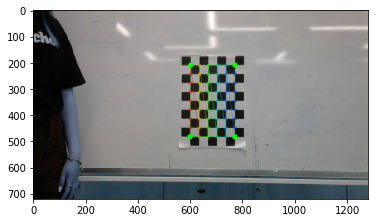

In [ ]:
# Define the number of corners in the chessboard pattern
CHESSBOARD_CORNER_NUM_X = 9
CHESSBOARD_CORNER_NUM_Y = 6

# Define the output file for the camera parameters
CAMERA_PARAMETERS_OUTPUT_FILE = "cam1.yaml"

# Define the termination criteria for corner detection
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# Prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(8,5,0)
# The Z-coordinate is 0 because the chessboard is assumed to lie in the XY plane
objp = np.zeros((CHESSBOARD_CORNER_NUM_X*CHESSBOARD_CORNER_NUM_Y,3), np.float32)
objp[:,:2] = np.mgrid[0:CHESSBOARD_CORNER_NUM_X,0:CHESSBOARD_CORNER_NUM_Y].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.

# Loop over all the images in the specified directory
for fname in images:
    # Load the image and convert it to grayscale
    img = cv.imread(fname)
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    
    # Find the chess board corners
    ret, corners = cv.findChessboardCorners(gray, (CHESSBOARD_CORNER_NUM_X,CHESSBOARD_CORNER_NUM_Y), None)
    
    # Define the corners
    BR_corner = corners[0, 0]
    BL_corner = corners[8, 0]
    TR_corner = corners[45, 0]
    TL_corner = corners[53, 0]
    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)
        corners2 = cv.cornerSubPix(gray,corners, (11,11), (-1,-1), criteria)
        imgpoints.append(corners)

        # Draw and display the corners
        cv.drawChessboardCorners(img, (CHESSBOARD_CORNER_NUM_X,CHESSBOARD_CORNER_NUM_Y), corners2, ret)
        
        # Draw 4 outer corners
        cv.circle(img, tuple(map(int, BR_corner)), 10, (0, 255, 0), -1)
        cv.circle(img, tuple(map(int, BL_corner)), 10, (0, 255, 0), -1)
        cv.circle(img, tuple(map(int, TR_corner)), 10, (0, 255, 0), -1)
        cv.circle(img, tuple(map(int, TL_corner)), 10, (0, 255, 0), -1)
        cv.line(img, tuple(map(int, BR_corner)), tuple(map(int, TR_corner)), (0,255,0), 1)
        cv.line(img, tuple(map(int, BL_corner)), tuple(map(int, TL_corner)), (0,255,0), 1)
        cv.line(img, tuple(map(int, BR_corner)), tuple(map(int, BL_corner)), (0,255,0), 1)
        cv.line(img, tuple(map(int, TR_corner)), tuple(map(int, TL_corner)), (0,255,0), 1)
        plt.imshow(img)

    else:
        print('Failed to find a chessboard in {}'.format(fname))

Convert the focal length to mm

In [ ]:
# Return the camera matrix
ret, camMatrix, distortionCoeff, rotationVectors, translationVectors = cv.calibrateCamera(
    objpoints, imgpoints, gray.shape[::-1], None, None)

# Displaying required output
print("\nCamera matrix:\n", camMatrix)
print("\nDistortion Parameters:\n", distortionCoeff)
# print("\nRotation Vectors:\n", rotationVectors)
# print("\nTranslation Vectors:\n", translationVectors)


Camera matrix:
 [[1.36765522e+03 0.00000000e+00 5.19832883e+02]
 [0.00000000e+00 1.38533550e+03 4.70723395e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]

Distortion Parameters:
 [[-1.57409748e-01  1.16297429e+00 -2.34649913e-03  5.56333394e-03
  -3.03143617e+00]]


In [ ]:
# Extract the focal length in pixels from the camera's intrinsic matrix
fx_pix = int(camMatrix[0][0])
fy_pix = int(camMatrix[1][1])

# Print the focal length in pixels
print("fx in pixel: ", fx_pix)
print("fy in pixel: ", fy_pix)

# Get the image height, image width, and number of channels
img_h, img_w, channel = img.shape

# Set the camera sensor width (in mm)
sensor_width = 3.58

# Convert the focal length from pixels to mm
fx_mm = fx_pix * sensor_width / img_w
fy_mm = fy_pix * sensor_width / img_w

# Print the focal length in mm
print("fx in mm: ", round(fx_mm,2))
print("fy in mm: ", round(fy_mm,2))

fx in pixel:  1367
fy in pixel:  1385
fx in mm:  3.82
fy in mm:  3.87


Produce Undistorted Images

In [ ]:
# Loop through all the images in the 'images' list
for fname in images:
    img = cv.imread(fname)
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    
    # Find the chessboard corners in the image using the findChessboardCorners function
    ret, corners = cv.findChessboardCorners(gray, (CHESSBOARD_CORNER_NUM_X,CHESSBOARD_CORNER_NUM_Y), None)
    
    # If the corners are found, proceed with undistorting the image
    if ret == True:
        
        # Get the height and width of the image
        h, w = img.shape[:2]

        # Calculate the optimal new camera matrix and region of interest (ROI) using the getOptimalNewCameraMatrix function
        newCamMatrix, roi = cv.getOptimalNewCameraMatrix(camMatrix, distortionCoeff, (w,h), 1, (w,h))

        # Apply the remapping to undistort the image using the initUndistortRectifyMap and remap functions
        mapx, mapy = cv.initUndistortRectifyMap(camMatrix, distortionCoeff, None, newCamMatrix, (w, h), 5)
        dst = cv.remap(img, mapx, mapy, cv.INTER_LINEAR)

        # Save the undistorted image to a file named 'caliResult.png'
        cv.imwrite('caliResult.png', dst)


Connect the chessboard corners

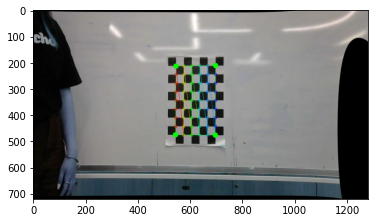

In [ ]:
caliImg = cv.imread('caliResult.png')
caliGray = cv.cvtColor(caliImg, cv.COLOR_BGR2GRAY)

# Find the chess board corners
ret, corners = cv.findChessboardCorners(caliGray, (CHESSBOARD_CORNER_NUM_X,CHESSBOARD_CORNER_NUM_Y), None)

# Define the corners
BR_corner = corners[0, 0]
BL_corner = corners[8, 0]
TR_corner = corners[45, 0]
TL_corner = corners[53, 0]

corners2 = cv.cornerSubPix(caliGray,corners, (11,11), (-1,-1), criteria)
# Draw and display the corners
cv.drawChessboardCorners(caliImg, (CHESSBOARD_CORNER_NUM_X,CHESSBOARD_CORNER_NUM_Y), corners2, ret)
# Draw 4 outer corners
cv.circle(caliImg, tuple(map(int, BR_corner)), 10, (0, 255, 0), -1)
cv.circle(caliImg, tuple(map(int, BL_corner)), 10, (0, 255, 0), -1)
cv.circle(caliImg, tuple(map(int, TR_corner)), 10, (0, 255, 0), -1)
cv.circle(caliImg, tuple(map(int, TL_corner)), 10, (0, 255, 0), -1)


cv.line(caliImg, tuple(map(int, BR_corner)), tuple(map(int, TR_corner)), (0,255,0), 1)
cv.line(caliImg, tuple(map(int, BL_corner)), tuple(map(int, TL_corner)), (0,255,0), 1)
cv.line(caliImg, tuple(map(int, BR_corner)), tuple(map(int, BL_corner)), (0,255,0), 1)
cv.line(caliImg, tuple(map(int, TR_corner)), tuple(map(int, TL_corner)), (0,255,0), 1)      
plt.imshow(caliImg)

(-0.5, 1279.5, 719.5, -0.5)

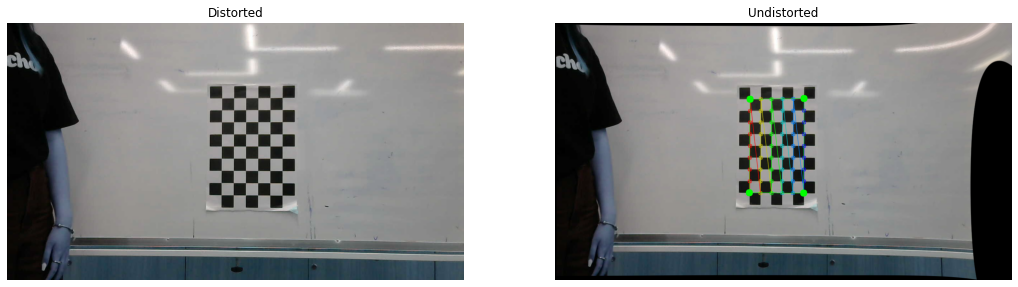

In [ ]:
plt.figure(figsize = [18, 10])
plt.subplot(1,2,1); plt.imshow(img); plt.title("Distorted"); plt.axis('off')
plt.subplot(1,2,2); plt.imshow(caliImg); plt.title("Undistorted"); plt.axis('off')